<a href="https://colab.research.google.com/github/michelucci/aadl2-code/blob/master/chapter8/02_Model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Histology Tissue Classification Project - Selection of models

## Import needed packages

In [0]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import pickle
import shutil
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure

In [4]:
tf.__version__

'1.13.1'

## Loading the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Loading the data from pickle files

In [0]:
base_dir = '/content/drive/My Drive/Book2-ch8/data/'

In [0]:
x_train=pickle.load(open(base_dir+'x_train.pkl', 'rb'))
x_test=pickle.load(open(base_dir+'x_test.pkl', 'rb'))
x_val=pickle.load(open(base_dir+'x_val.pkl', 'rb'))

In [0]:
y_train=pickle.load(open(base_dir+'y_train.pkl', 'rb'))
y_test=pickle.load(open(base_dir+'y_test.pkl', 'rb'))
y_val=pickle.load(open(base_dir+'y_val.pkl', 'rb'))

### Basics checks

In [9]:
print('1- Training set:', x_train.shape, y_train.shape)
print('2- Validation set:', x_val.shape, y_val.shape)
print('3- Testing set:', x_test.shape, y_test.shape)

1- Training set: (3000, 150, 150, 3) (3000, 8)
2- Validation set: (1000, 150, 150, 3) (1000, 8)
3- Testing set: (1000, 150, 150, 3) (1000, 8)


In [10]:
np.amin(x_train), np.amin(x_test), np.amin(x_val)

(0.0, 0.0, 0.0)

In [11]:
np.amax(x_train), np.amax(x_test), np.amax(x_val)

(1.0, 1.0, 1.0)

## Building models

### Defining the input shape

In [12]:
(x_train.shape[1],x_train.shape[2],x_train.shape[3])

(150, 150, 3)

In [0]:
input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])

In [14]:
input_shape

(150, 150, 3)

### Define plot style

In [0]:
plt.style.use('seaborn-ticks')

In [0]:
def plot_acc_loss(history):
    # plot the training loss and accuracy
    fig = plt.figure(figsize=(9, 3), dpi=100)
    plt.subplots_adjust(wspace = 0.6 )
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot(np.arange(0, EPOCHS), history.history['acc'], 'b', label='training accuracy')
    ax1.plot(np.arange(0, EPOCHS), history.history['val_acc'], 'r', label='validation accuracy');
    ax1.set_title('Accuracy')
    ax1.set_xlabel("Number of epochs ")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="best")


    ax2.plot(np.arange(0, EPOCHS), history.history["loss"], label="training loss")
    ax2.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="validation loss")
    ax2.set_title("Loss")
    ax2.set_xlabel("Number of epochs ")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="best");
    
    fig.tight_layout()
    
    print('Loss:')
    print('  - loss [training dataset]: {0:.3f}'.format(history.history['loss'][-1]))
    print('  - loss [validation dataset: {0:.3f}'.format(history.history['val_loss'][-1]))
    print('')
    print('Accuracy:')
    print('  - accuracy [training dataset]: {:.2f}%'.format(100*history.history['acc'][-1]))
    print('  - accuracy [validation dataset: {:.2f}%'.format(100*history.history['val_acc'][-1]))
    
    return fig

### CNN model v1

Loss:
  - loss [training dataset]: 0.541
  - loss [validation dataset: 0.610

Accuracy:
  - accuracy [training dataset]: 78.23%
  - accuracy [validation dataset: 76.60%
  
100 epochs
batch size 256

In [0]:
def model_cnn_v1():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 3, 3, input_shape=input_shape))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, 3, 3))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Activation('sigmoid'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v1=model_cnn_v1()

# take a look at the model summary
model_cnn_v1.summary()

# save weight before training
initial_weights = model_cnn_v1.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
__________

In [0]:
%%time

# set to the original weights for testing other pipelines
model_cnn_v1.set_weights(initial_weights)

# define path to save the mnodel
path_model=base_dir+'model_cnn_v1.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=200
BATCH_SIZE=256

history=model_cnn_v1.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/200
2816/3000 [===========================>..] - ETA: 0s - loss: 2.0348 - acc: 0.2031
Epoch 00001: val_loss improved from inf to 1.94619, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 2s 587us/sample - loss: 2.0315 - acc: 0.2077 - val_loss: 1.9462 - val_acc: 0.3470
Epoch 2/200
2816/3000 [===========================>..] - ETA: 0s - loss: 1.8538 - acc: 0.2532
Epoch 00002: val_loss improved from 1.94619 to 1.69167, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 1s 375us/sample - loss: 1.8489 - acc: 0.2503 - val_loss: 1.6917 - val_acc: 0.3500
Epoch 3/200
2816/3000 [===========================>..] - ETA: 0s - loss: 1.6901 - acc: 0.2560
Epoch 00003: val_loss improved from 1.69167 to 1.54393, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v1.weights.best

In [0]:
# 2:50 time needed on Google Colab
fig = plot_acc_loss(history)
fig.savefig(base_dir+'cnn1.png', dpi = 300)

NameError: ignored

### CNN model v2

Loss:
  - loss [training dataset]: 0.046
  - loss [validation dataset: 0.951

Accuracy:
  - accuracy [training dataset]: 98.87%
  - accuracy [validation dataset: 78.70%
  
50 epochs
batch size 64

In [0]:
def model_cnn_v2():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256,activation = "relu"))          
    model.add(tf.keras.layers.Dense(64,activation = "relu"))
    model.add(tf.keras.layers.Dense(32,activation = "relu"))

    model.add(tf.keras.layers.Dense(8, activation = "softmax"))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v2=model_cnn_v2()

# take a look at the model summary
model_cnn_v2.summary()

# save weight before training
initial_weights = model_cnn_v2.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 128)     9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
__________

In [0]:
%%time

# set to the original weights for testing other pipelines
model_cnn_v2.set_weights(initial_weights)

# define path to save the mnodel
path_model=base_dir + 'model_cnn_v2.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=50
BATCH_SIZE=64

history=model_cnn_v2.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
2944/3000 [============================>.] - ETA: 0s - loss: 1.7540 - acc: 0.2218
Epoch 00001: val_loss improved from inf to 1.53836, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v2.weights.best.hdf5
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.7508 - acc: 0.2217 - val_loss: 1.5384 - val_acc: 0.4940
Epoch 2/50
2944/3000 [============================>.] - ETA: 0s - loss: 1.2801 - acc: 0.4389
Epoch 00002: val_loss improved from 1.53836 to 1.18151, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v2.weights.best.hdf5
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.2745 - acc: 0.4413 - val_loss: 1.1815 - val_acc: 0.4200
Epoch 3/50
2944/3000 [============================>.] - ETA: 0s - loss: 0.9531 - acc: 0.5659
Epoch 00003: val_loss improved from 1.18151 to 1.11156, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v2.weights.best.hdf5
3

Loss:
  - loss [training dataset]: 0.021
  - loss [validation dataset: 1.459

Accuracy:
  - accuracy [training dataset]: 99.53%
  - accuracy [validation dataset: 74.10%


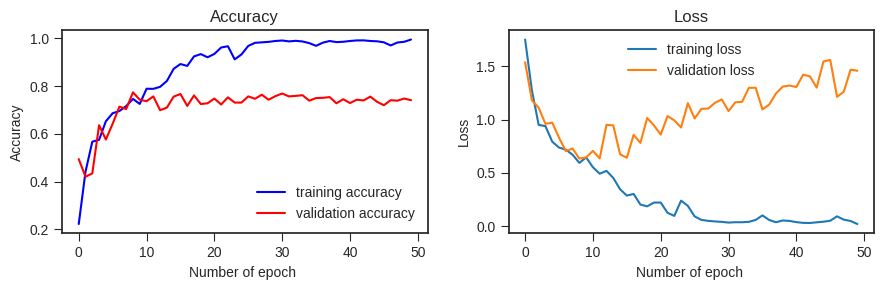

In [0]:
fig = plot_acc_loss(history)
fig.savefig(base_dir+'cnn2.png', dpi = 300)

### CNN model v3

Loss:
  - loss [training dataset]: 0.132
  - loss [validation dataset: 0.633

Accuracy:
  - accuracy [training dataset]: 95.90%
  - accuracy [validation dataset: 79.00%
  
   
50 epochs
batch size 64

In [0]:
def model_cnn_v3():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3)) 

    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3)) 

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3))

    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3))
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    model.add(tf.keras.layers.Dense(8, activation = 'softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v3=model_cnn_v3()

# take a look at the model summary
model_cnn_v3.summary()

# save weight before training
initial_weights = model_cnn_v3.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9248      
__________

In [0]:
%%time
# set to the original weights for testing other pipelines
model_cnn_v3.set_weights(initial_weights)

# define path to save the mnodel
path_model=base_dir + 'model_cnn_v3.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=50
#BATCH_SIZE=256
#BATCH_SIZE=128
BATCH_SIZE=64

history=model_cnn_v3.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
2944/3000 [============================>.] - ETA: 0s - loss: 1.6883 - acc: 0.2493
Epoch 00001: val_loss improved from inf to 1.63613, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v3.weights.best.hdf5
3000/3000 [==============================] - 6s 2ms/sample - loss: 1.6822 - acc: 0.2520 - val_loss: 1.6361 - val_acc: 0.3090
Epoch 2/50
2944/3000 [============================>.] - ETA: 0s - loss: 1.3588 - acc: 0.3709
Epoch 00002: val_loss improved from 1.63613 to 1.39190, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v3.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/sample - loss: 1.3527 - acc: 0.3727 - val_loss: 1.3919 - val_acc: 0.2850
Epoch 3/50
2944/3000 [============================>.] - ETA: 0s - loss: 1.0496 - acc: 0.4946
Epoch 00003: val_loss did not improve from 1.39190
3000/3000 [==============================] - 5s 2ms/sample - loss: 1.0461 - acc: 0.4973 - va

Loss:
  - loss [training dataset]: 0.089
  - loss [validation dataset: 0.688

Accuracy:
  - accuracy [training dataset]: 96.90%
  - accuracy [validation dataset: 78.50%


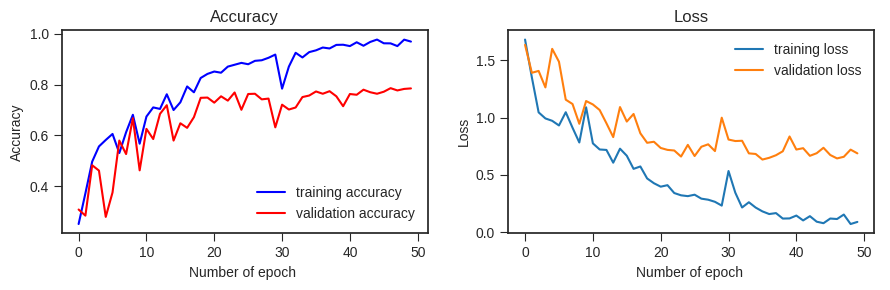

In [0]:
fig = plot_acc_loss(history)
fig.savefig(base_dir+'cnn3.png', dpi = 300)

### VGG16 model v4 and retraining only the last 4 layers

Loss:
  - loss [training dataset]: 0.005
  - loss [validation dataset: 0.624

Accuracy:
  - accuracy [training dataset]: 99.90%
  - accuracy [validation dataset: 90.10%
  
   
30 epochs
batch size 128

In [20]:
def model_vgg16_v4():
    
    # load the VGG model
    vgg_conv = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
    
    # freeze the layers except the last 4 layers
    for layer in vgg_conv.layers[:-4]:
          layer.trainable = False
 
    # Check the trainable status of the individual layers
    for layer in vgg_conv.layers:
        print(layer, layer.trainable)
        
    # create the model
    model = tf.keras.models.Sequential()
 
    # add the vgg convolutional base model
    model.add(vgg_conv)
 
    # add new layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(8, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_vgg16_v4=model_vgg16_v4()

# take a look at the model summary
model_vgg16_v4.summary()

# save weight before training
initial_weights = model_vgg16_v4.get_weights()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efdce813f28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdcf5b9da0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efe3a819c18> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7efdce812978> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdce8129b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdcdfd4eb8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7efdcdfa0c18> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdcdf8c4a8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdcdf3beb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdcdef4668> False
<tensorflow

In [18]:
%%time
# set to the original weights for testing other pipelines
model_vgg16_v4.set_weights(initial_weights)

# define path to save the mnodel
path_model=base_dir+'model_vgg16_v4.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=30
BATCH_SIZE=128

history=model_vgg16_v4.fit(x_train,
                           y_train,
                           batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=(x_test, y_test),
                           callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
2944/3000 [============================>.] - ETA: 0s - loss: 1.8027 - acc: 0.3651
Epoch 00001: val_loss improved from inf to 1.26572, saving model to /content/drive/My Drive/Book2-ch8/data/model_vgg16_v4.weights.best.hdf5
3000/3000 [==============================] - 50s 17ms/sample - loss: 1.7953 - acc: 0.3670 - val_loss: 1.2657 - val_acc: 0.4540
Epoch 2/30
2944/3000 [============================>.] - ETA: 0s - loss: 1.1243 - acc: 0.5350
Epoch 00002: val_loss improved from 1.26572 to 0.92835, saving model to /content/drive/My Drive/Book2-ch8/data/model_vgg16_v4.weights.best.hdf5
3000/3000 [==============================] - 23s 8ms/sample - loss: 1.1206 - acc: 0.5363 - val_loss: 0.9283 - val_acc: 0.6440
Epoch 3/30
2944/3000 [============================>.] - ETA: 0s - loss: 0.9851 - acc: 0.6332
Epoch 00003: val_loss improved from 0.92835 to 0.72333, saving model to /content/drive/M

Loss:
  - loss [training dataset]: 0.053
  - loss [validation dataset: 0.676

Accuracy:
  - accuracy [training dataset]: 98.53%
  - accuracy [validation dataset: 86.90%


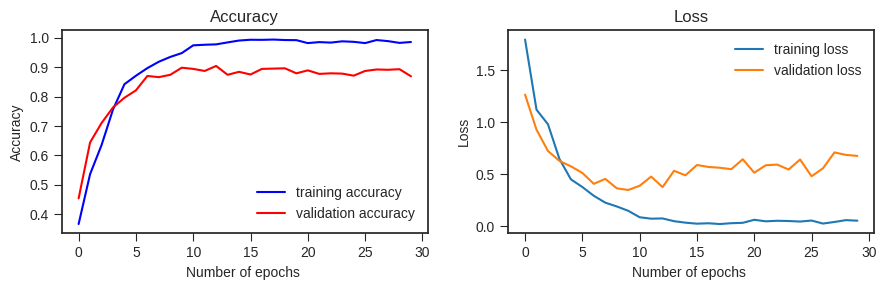

In [19]:
fig = plot_acc_loss(history)
fig.savefig(base_dir+'cnn_vgg4.png', dpi = 300)

### CNN model v1 with data augmentation

In [0]:
# construct the image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True, 
                             fill_mode="nearest")

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- width_shift and 
- height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [0]:
datagen.fit(x_train)

In [0]:
%%time

# set to the original weights for testing other pipelines
model_cnn_v1.set_weights(initial_weights)

# define path to save the mnodel
path_model=base_dir+'model_cnn_v1_aug.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=100
BATCH_SIZE=256


history=model_cnn_v1.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                                   validation_data=(x_test, y_test),
                                   steps_per_epoch=len(x_train) // BATCH_SIZE,
                                   epochs=EPOCHS, 
                                   callbacks=[checkpointer])

Epoch 1/100
1000/1000 [==============================] - 0s 231us/sample - loss: 1.9711 - acc: 0.2070

Epoch 00001: val_loss improved from inf to 1.97121, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v1_aug.weights.best.hdf5
12/12 [==============================] - 12s 1s/step - loss: 2.0451 - acc: 0.1620 - val_loss: 1.9712 - val_acc: 0.2070
Epoch 2/100
1000/1000 [==============================] - 0s 171us/sample - loss: 1.6782 - acc: 0.3740

Epoch 00002: val_loss improved from 1.97121 to 1.67820, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v1_aug.weights.best.hdf5
12/12 [==============================] - 12s 1s/step - loss: 1.8741 - acc: 0.2617 - val_loss: 1.6782 - val_acc: 0.3740
Epoch 3/100
1000/1000 [==============================] - 0s 181us/sample - loss: 1.4954 - acc: 0.3360

Epoch 00003: val_loss improved from 1.67820 to 1.49567, saving model to /content/drive/My Drive/Book2-ch8/data/model_cnn_v1_aug.weights.best.hdf5
12/12 [============

Loss:
  - loss [training dataset]: 0.695
  - loss [validation dataset: 0.654

Accuracy:
  - accuracy [training dataset]: 70.23%
  - accuracy [validation dataset: 77.90%


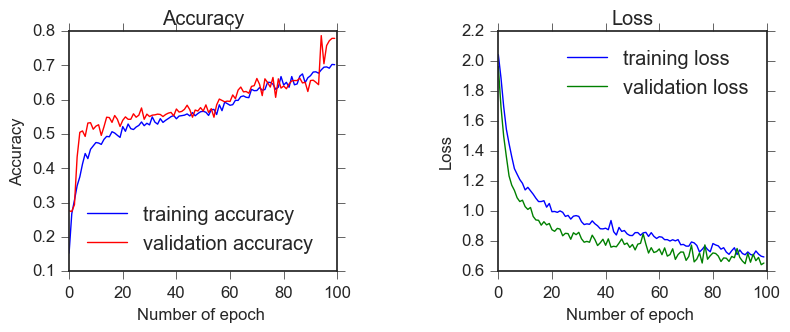

In [0]:
plot_acc_loss(history)

### CNN model v1 with data augmentation and histogram equalization

In [0]:
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

In [0]:
# construct the image generator for data augmentation
datagen_hist_train = ImageDataGenerator(rotation_range=40, 
                                        width_shift_range=0.2,
                                        height_shift_range=0.2, 
                                        shear_range=0.2, 
                                        zoom_range=0.2,
                                        horizontal_flip=True, 
                                        fill_mode="nearest",
                                        preprocessing_function=AHE)

In [0]:
datagen_hist_test = ImageDataGenerator(preprocessing_function=AHE)

In [0]:
datagen_hist_train.fit(x_train)

In [0]:
datagen_hist_test.fit(x_test)

In [0]:
%%time

# set to the original weights for testing other pipelines
model_cnn_v1.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_cnn_v1_aug_hist.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=100
BATCH_SIZE=256
#BATCH_SIZE=128
#BATCH_SIZE=64


history=model_cnn_v1.fit_generator(datagen_hist_train.flow(x_train, y_train, batch_size=BATCH_SIZE),
                                   validation_data=datagen_hist_test.flow(x_test, y_test, batch_size=len(x_test)),
                                   steps_per_epoch=len(x_train) // BATCH_SIZE,
                                   epochs=EPOCHS, 
                                   callbacks=[checkpointer])

Epoch 1/100
10/11 [==========================>...] - ETA: 6s - loss: 2.0403 - acc: 0.1629 
Epoch 00001: val_loss improved from inf to 1.92117, saving model to ./results/model_cnn_v1_aug_hist.weights.best.hdf5
11/11 [==============================] - 106s 10s/step - loss: 2.0342 - acc: 0.1663 - val_loss: 1.9212 - val_acc: 0.2340
Epoch 2/100
10/11 [==========================>...] - ETA: 8s - loss: 1.8339 - acc: 0.2499 
Epoch 00002: val_loss improved from 1.92117 to 1.66884, saving model to ./results/model_cnn_v1_aug_hist.weights.best.hdf5
11/11 [==============================] - 138s 13s/step - loss: 1.8269 - acc: 0.2469 - val_loss: 1.6688 - val_acc: 0.2500
Epoch 3/100
10/11 [==========================>...] - ETA: 7s - loss: 1.7067 - acc: 0.2473 
Epoch 00003: val_loss improved from 1.66884 to 1.60032, saving model to ./results/model_cnn_v1_aug_hist.weights.best.hdf5
11/11 [==============================] - 125s 11s/step - loss: 1.7031 - acc: 0.2476 - val_loss: 1.6003 - val_acc: 0.2890
Ep

Loss:
  - loss [training dataset]: 0.788
  - loss [validation dataset: 0.745

Accuracy:
  - accuracy [training dataset]: 62.43%
  - accuracy [validation dataset: 61.50%


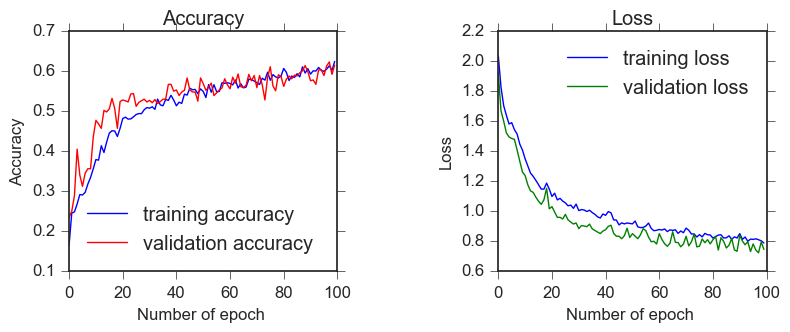

In [0]:
plot_acc_loss(history)

### VGG16 model v4 with data augmentation

In [23]:
%%time
# set to the original weights for testing other pipelines
model_vgg16_v4.set_weights(initial_weights)

# define path to save the mnodel
path_model=base_dir+'model_vgg16_v4_aug.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=50
BATCH_SIZE=128

history=model_vgg16_v4.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                                     validation_data=(x_test, y_test),
                                     #steps_per_epoch=len(x_train) // BATCH_SIZE,
                                     epochs=EPOCHS, 
                                     callbacks=[checkpointer])

Epoch 1/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.4939 - acc: 0.3540

Epoch 00001: val_loss improved from inf to 1.49236, saving model to /content/drive/My Drive/Book2-ch8/data/model_vgg16_v4_aug.weights.best.hdf5
24/24 [==============================] - 18s 739ms/step - loss: 1.7739 - acc: 0.3663 - val_loss: 1.4924 - val_acc: 0.3540
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.3869 - acc: 0.3980

Epoch 00002: val_loss improved from 1.49236 to 1.38597, saving model to /content/drive/My Drive/Book2-ch8/data/model_vgg16_v4_aug.weights.best.hdf5
24/24 [==============================] - 18s 757ms/step - loss: 1.6601 - acc: 0.3413 - val_loss: 1.3860 - val_acc: 0.3980
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.2029 - acc: 0.4880

Epoch 00003: val_loss improved from 1.38597 to 1.20120, saving model to /content/drive/My Drive/Book2-ch8/data/model_vgg16_v4_aug.weights.best.hdf5
24/24 [=========

In [0]:
fig = plot_acc_loss(history)
fig.savefig(base_dir+'cnn_vgg4_aug.png', dpi = 300)